In [1]:
#!/home/anuj.mishra/anaconda3/envs/gwpy/bin/python

## Code to generate microlensed population.
## Authors: Anuj Mishra and Apratim Ganguly.

import numpy as np

import scipy
from scipy.interpolate import interp1d
from scipy.integrate import quad

import bilby
import gwpopulation as gwpop
import json
import argparse
import lal
import pycbc
from pycbc import psd
import matplotlib.pyplot as plt
import time

import sys
# sys.path.append('/home/anuj.mishra/git_repos/GWMAT/src/')
sys.path.append('/home/anuj/git_repos/GWMAT/src/')
import py_lgw
lgw = py_lgw.lensed_wf_gen()
csm = py_lgw.cosmology()

In [2]:
### 1. Find max z possible
print('# Finding maximum z to consider:')
z_maxs = []

m_tot, q = 210, 1
Mlz, y = 0, 5  # Unlesned Case

m1, m2 = lgw.mtot_q_to_m1m2(m_tot, q)

init_prms = dict(f_low=20, f_ref=20, sample_rate=2048, approximant="IMRPhenomXP", ifo_list=['H1', 'L1', 'V1'])
lens_prms = dict(m_lens=Mlz, y_lens=y, z_lens=0, Ff_data=None)

cbc_prms = dict(mass_1=m1, mass_2=m2, luminosity_distance=1000, 
                ra=0.7, dec=0.7, theta_jn=0.5, polarization=0., coa_phase=0., trig_time=1234567)
psd_prms = dict(Noise='True', psd_H1='O4', psd_L1='O4', psd_V1='O4') #psd_duration=psd_duration, psd_sample_rate=psd_sample_rate
prms = {**init_prms, **lens_prms, **cbc_prms, **psd_prms}
lgw.f_low, lgw.f_ref = prms['f_low'], prms['f_ref']
lgw.sample_rate, lgw.apx = prms['sample_rate'], prms['approximant']

d_max = lgw.network_optimal_snr_to_distance(8, **prms)
z_max = csm.z_at_d_luminosity(d_max) 
z_maxs.append(z_max)
print('{{Mlz, y, M, q}}: {{ {}, {}, {}, {} }} '.format(Mlz, y, m_tot, q) )
print('d_max: ', d_max)
print('z_max: ', z_max)

# Finding maximum z to consider:
{Mlz, y, M, q}: { 0, 5, 210, 1 } 
d_max:  8328.062919406093
z_max:  1.21337890625


/home/anuj/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/models/mass.py:634: RuntimeWarning: overflow encountered in exp
  window[smoothing_region] = 1 / (xp.exp(exponent) + 1)
/home/anuj/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/models/mass.py:573: RuntimeWarning: invalid value encountered in true_divide
  p_q /= self.norm_p_q(beta=beta, mmin=mmin, delta_m=delta_m)


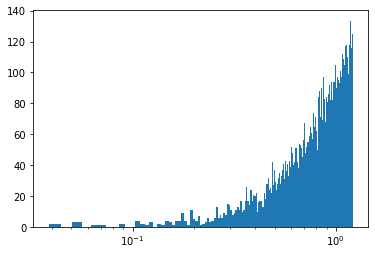

In [3]:
## 2. Setting Priors

start = time.time()

proc_ID = 0 #int(sys.argv[1])
#outfile = 'BBH_' + str(proc_ID) + '_' #args.outfile
#outdir = '/home/anuj.mishra/git_repos/microlensing_effects_on_pe/data/pop_data/injection_set_2/'
#outdir = '/home/anuj/git_repos/microlensing_effects_on_pe/data/pop_data/injection_set_2/'


# files to input
# pop_file = "/home/anuj.mishra/git_repos/microlensing-meets-imrct/data/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json"
pop_file = "/home/anuj/git_repos/microlensing-meets-imrct/data/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json"

# read in the parameters for the population config and take
# the maP parameters
pop_data = bilby.core.result.read_in_result(filename=pop_file)
log_likelihood = pop_data.posterior["log_likelihood"]
log_prior = pop_data.posterior["log_prior"]
params = pop_data.posterior.iloc[np.argmax(log_prior + log_likelihood)]
pop_params = params.to_dict()


# setting up model dependant distributions
mass_model = gwpop.models.mass.SinglePeakSmoothedMassDistribution()
z_model = gwpop.models.redshift.PowerLawRedshift()
high_z_arr = np.logspace(np.log10(np.max(z_model.zs) + 0.01), np.log10(z_max), 1000)
interp_params = dict(
    mass_1=mass_model.m1s[::2],
    mass_ratio=mass_model.qs,
    a_1=np.linspace(0, 0.99, 500),
    a_2=np.linspace(0, 0.99, 500),
    cos_tilt_1=np.linspace(-1, 1, 500),
    cos_tilt_2=np.linspace(-1, 1, 500),
    #redshift=z_model.zs    #np.concatenate((z_model.zs, high_z_arr)),
)
p_m1 = mass_model.p_m1(
    interp_params,
    **{
        "alpha": pop_params["alpha"],
        "mmin": pop_params["mmin"],
        "mmax": pop_params["mmax"],
        "lam": pop_params["lam"],
        "mpp": pop_params["mpp"],
        "sigpp": pop_params["sigpp"],
        "delta_m": pop_params["delta_m"],
    }
)

p_q = mass_model.p_q(
    {
        "mass_1": interp_params["mass_1"],
        "mass_ratio": interp_params["mass_ratio"],
    },
    **{
        "beta": pop_params["beta"],
        "mmin": pop_params["mmin"],
        "delta_m": pop_params["delta_m"],
    }
)

p_tilt = gwpop.models.spin.iid_spin_orientation_gaussian_isotropic(
    interp_params, pop_params["xi_spin"], pop_params["sigma_spin"])


# make the prior by interpolation
m1_prior = bilby.core.prior.interpolated.Interped(
    interp_params["mass_1"], p_m1, minimum=2, maximum=100)  # source frame mass prior

tilt_prior = bilby.core.prior.interpolated.Interped(
    interp_params["cos_tilt_1"], p_tilt, minimum=-1, maximum=1)

# p_z = z_model(interp_params, **{"lamb": pop_params["lamb"]})
# z_prior = bilby.core.prior.interpolated.Interped(
#     interp_params["redshift"],
#     p_z,
#     minimum=0.001,
#     maximum=z_max  #max(interp_params["redshift"])
# )

# z_prior = bilby.core.prior.PowerLaw(
#     name="yl", minimum=0.001, maximum=z_max, alpha = 2.0)


full_parameters, _ = gwpop.conversions.convert_to_beta_parameters(pop_params)

# setting prior for parameters not considered in populations
phi_prior = bilby.core.prior.Uniform(
    name="phi", minimum=0.0, maximum=2 * np.pi, boundary="periodic")

ra_prior = bilby.core.prior.Uniform(
    name="ra", minimum=0.0, maximum=2 * np.pi, boundary="periodic")

dec_prior = bilby.core.prior.Cosine(name="dec")
phase_prior = bilby.core.prior.Uniform(
    name="phase", minimum=0.0, maximum=2 * np.pi, boundary="periodic")

iota_prior = bilby.core.prior.Sine(name="theta_jn")

psi_prior = bilby.core.prior.Uniform(
    name="psi", minimum=0.0, maximum=np.pi, boundary="periodic")

ml_prior = bilby.core.prior.LogUniform(   
    name="ml", minimum=1e1, maximum=1e5)

yl_prior = bilby.core.prior.PowerLaw(
    name="yl", minimum=0.01, maximum=3.0, alpha = 1.0)



# # Madau, Fragos 2016: https://arxiv.org/pdf/1606.07887.pdf
# def madau_fragos_pop_i_ii(z):
#     rate = 0.01 * ( (1 + z)**2.6 )/( 1 + ( (1+z)/3.2 )**6.2 ) 
#     return rate

# Fishback 2018: https://arxiv.org/pdf/1805.10270.pdf
def madau_dickinson_pop_i_ii(z):
    rate = 0.015 * ( (1 + z)**2.7 )/( 1 + ( (1+z)/2.9 )**5.6 ) 
    return rate

def E_z(z):
    Omega_m = 0.315           #matter_density
    Omega_lambda = 0.685      #dark_energy_density
    Omega_r = 1 - Omega_m - Omega_lambda   #radiation_energy_density
    return np.sqrt(Omega_r*(1 + z)**4 + Omega_m*(1 + z)**3 + Omega_lambda)

def dVc_dz(z):
    D_H = csm.DHo
    D_A = csm.d_ang_dia(z)
    Ez = E_z(z)
    d_Omega = 4*np.pi
    dVc_dz_val = d_Omega * D_H * (1 + z)**2 * D_A**2 / Ez * 1e-12
    return dVc_dz_val

def merger_rate_density(z):
    return  madau_dickinson_pop_i_ii(z) * dVc_dz(z)/(1+z)

# follows madau-dickinson merger rate
def merger_rate_probability_density(z1, z2, num=int(1e4)):
    norm = quad( merger_rate_density, z1, z2 )[0]
    z_arr = np.logspace(np.log10(z1), np.log10(z2), num=num, base=10)
    pz_arr = np.array( list( map( lambda z: merger_rate_density(z)/norm, z_arr)))
    i_pz = interp1d(z_arr, pz_arr)
    return i_pz

z_min, z_max = 1e-3, z_max
z_arr = np.logspace(np.log10(z_min), np.log10(z_max), int(5e6))
z_prior = bilby.core.prior.interpolated.Interped(
    z_arr,
    merger_rate_probability_density(z_min, z_max)(z_arr),
    minimum=z_min,
    maximum=z_max
)

zs_samps = z_prior.sample(10000)
plt.hist(zs_samps, bins=200)
plt.xscale('log')
plt.show()

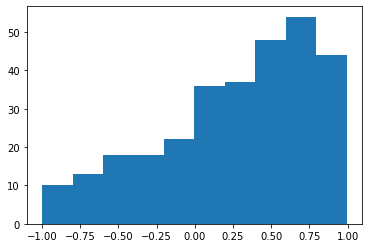

In [4]:
tilts = tilt_prior.sample(300)
plt.hist(tilts, bins=10)
# plt.xscale('log')
plt.show()

In [5]:

## 3. Population Generation

## master function to compute SNRs
def compute_optimal_snr(init_prms, inj_prms):  
    # computes ML signl optimal SNR using ML template
    m_tot = inj_prms['mass_1'] + inj_prms['mass_2']
    if m_tot > 20:
        init_prms['sample_rate'] = 2048
    else:
        init_prms['sample_rate'] = 4096
    
    lgw.f_low = init_prms['f_low']
    lgw.f_ref = init_prms['f_ref']
    lgw.f_high = init_prms['f_high']
    lgw.sample_rate = init_prms['sample_rate'] 
    lgw.apx = init_prms['approximant']
    
    lens_prms = dict(m_lens=0, y_lens=5, z_lens=0, Ff_data=None)   # UNLENSED CASE
    cbc_prms = dict(mass_1=inj_prms['mass_1'], mass_2=inj_prms['mass_2'], 
                    a_1=inj_prms['a_1'], a_2=inj_prms['a_2'], tilt_1=inj_prms['tilt_1'], tilt_2=inj_prms['tilt_2'], 
                    phi_jl=inj_prms['phi_jl'], phi_12=inj_prms['phi_12'], theta_jn=inj_prms['theta_jn'],
                    luminosity_distance=inj_prms['luminosity_distance'],
                    ra=inj_prms['ra'], dec=inj_prms['dec'], polarization=inj_prms['psi'], 
                    coa_phase=inj_prms['phase'], trig_time=inj_prms['geocent_time'], rwrap=0.2)
    psd_prms = dict(Noise='True', psd_H1='O4', psd_L1='O4', psd_V1='O4') #psd_duration=psd_duration, psd_sample_rate=psd_sample_rate
    prms = {**init_prms, **lens_prms, **cbc_prms, **psd_prms}
    
    try:
        wfs_res = lgw.sim_lensed_noisy_wf_gen_with_snr(**prms)
        net_opt_snr = wfs_res['network_optimal_snr']
        #net_mf_snr = np.linalg.norm([wfs_res['matched_filter_snr_H1'], wfs_res['matched_filter_snr_L1'], wfs_res['matched_filter_snr_V1']])
        #print(net_opt_snr, net_mf_snr)
    except (RuntimeError, ValueError):   
        # Runtime error occurs when WF can not be generated for the given arguments.
        # Value Error occurs, .e.g. when f_low > f_high.
        net_opt_snr = 0.0

    return net_opt_snr

## Sampling

sampling_frequency = None # will be decided based on binary mass  #2048 #4096
waveform_approximant = "IMRPhenomXP"
minimum_frequency = 20.0
reference_frequency = minimum_frequency
f_high = None
init_prms = dict(f_low=minimum_frequency, f_high=None, f_ref=reference_frequency, sample_rate=sampling_frequency, approximant=waveform_approximant)

# O4a tentative dates
t_O4_start = may_01_2023 = 1366934418  # ~ O4 begins
t_O4_end = nov_01_2024 = 1414454418  # ~ O4 ends 
#time_gps = 1126259462  # time of GW150914


N_sim = 1e1  # total no. of detected population we want
chunck_size = int(5e1)
N_inj = 0.0  # current no. of detect population
ND = 0.0  # total no. of non-detected population we want

injections = dict()
detected = dict()
non_detected = dict()
min_bh_m_z = 4   # minimum redhshifted black hole mass allowed
ifos_array = ["H1", "L1", "V1"]  # hard-coded

# generate the data by chuncks as much as possible
iternum = 0
while N_inj < N_sim:
    iternum += 1
    print('\nIteration #%s'%(iternum))
    # do everything that can be done in a vectorial way first
    params = dict()
    
    # mass of the binary
    m1s_src = m1_prior.sample(size=chunck_size)
    zs = z_prior.sample(size=chunck_size)
    m1_det = m1s_src*(1+zs)
    m1_det = m1_det[m1_det > min_bh_m_z]
    while( len(m1_det) < chunck_size ):
        m1s_src = m1_prior.sample(size=chunck_size)
        zs = z_prior.sample(size=chunck_size)
        m1_det = np.concatenate(( m1_det, m1s_src*(1+zs) ))
    params["mass_1"]  = m1_det[:chunck_size] 
    params["mass_2"] = np.zeros(len(params["mass_1"]))  # placeholder temp values
    
    
    # spin parameters
    params["a_1"] = np.random.beta(full_parameters["alpha_chi"], full_parameters["beta_chi"], size=chunck_size)
    params["a_2"] = np.random.beta(full_parameters["alpha_chi"], full_parameters["beta_chi"], size=chunck_size)
    ct1 = tilt_prior.sample(size=chunck_size)
    ct2 = tilt_prior.sample(size=chunck_size)
    params["tilt_1"] = np.arccos(ct1)
    params["tilt_2"] = np.arccos(ct2)
    params["phi_12"] = phi_prior.sample(size=chunck_size)
    params["phi_jl"] = phi_prior.sample(size=chunck_size)
    
    # euler angles
    params["theta_jn"] = iota_prior.sample(size=chunck_size)
    params["psi"] = psi_prior.sample(size=chunck_size)
    params["phase"] = phase_prior.sample(size=chunck_size)
    
    # spacetime coordinates
    params["ra"] = ra_prior.sample(size=chunck_size)
    params["dec"] = dec_prior.sample(size=chunck_size)
    params["luminosity_distance"] = bilby.gw.conversion.redshift_to_luminosity_distance(zs)
    params["geocent_time"] = np.random.uniform(t_O4_start, t_O4_end, size=chunck_size)
    

    seeds = np.random.randint(low=0, high=int(1e5), size=chunck_size)

    approx_durations = []  # store the duration

    # we need to loop over all the events to make the correct function
    for i in range(len(params["mass_1"])):
        q_min = min_bh_m_z/params["mass_1"][i]
        q_max = max(interp_params["mass_ratio"])
   
        q_prior = bilby.core.prior.interpolated.Interped(
        interp_params["mass_ratio"],
        p_q,
        minimum=q_min,
        maximum=q_max,
        )
        params["mass_2"][i] = params["mass_1"][i] * float(q_prior.sample())
        
        wf_duration = lgw.rough_wf_duration(m1 = params["mass_1"][i],
                                            m2 = params["mass_2"][i],
                                            f_low = minimum_frequency)
        approx_durations.append(wf_duration["rough_duration_for_PE"])

    durations = np.array(approx_durations)

    # go through all events to inject them and test them
    for i in range(chunck_size):
        # quit the loop if enough events have been detected
        if N_inj > (N_sim - 1):
            break
        
        # inject the signal using Pycbc and check Optimal SNR
        ps = {k: params[k][i] for k in params.keys()}
        ps = bilby.gw.conversion.generate_all_bbh_parameters(ps, **{'reference_frequency':reference_frequency})
        print('\n',ps)
        rho_opt = compute_optimal_snr(init_prms = init_prms, inj_prms = ps)
        print('snr: ', rho_opt)
        
        if rho_opt > 8:
            print("\nFound injection %i / %i" % (N_inj+1, N_sim))
            # save output
            injections["%i" % N_inj] = dict(
                parameters=ps,
                duration=durations[i],
                snr=rho_opt,
                seed=str(seeds[i]),
                ifos=ifos_array,
            )
            
            N_inj += 1

        else:
            print('\nNot-Detected')
            non_detected["%i" % ND] = dict(
                parameters=ps,
                duration=durations[i],
                snr=rho_opt,
                seed=str(seeds[i]),
                ifos=ifos_array,
            )
            # print('not-detected')
            ND += 1
            

# # now that we have what we need, we can save it
# print(" ")
# print("######################################################")
# print(" ")
# print("Generation is DONE, now saving the data...")
# print(" ")
# print("######################################################")
# print(" ")

# # args = parser.parse_args()
# # outfile = args.outfile

# injections_file = outdir + outfile + "Injections_lensed"
# non_detected_file = outdir + outfile + "NonDetected_lensed"


# class NpEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.integer):
#             return int(obj)
#         if isinstance(obj, np.floating):
#             return float(obj)
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return super(NpEncoder, self).default(obj)

# with open("%s.json" %injections_file, "w") as fd:
#     json.dump(injections, fd, indent=4, cls=NpEncoder)

# with open("%s.json" %non_detected_file, "w") as fnd:
#     json.dump(non_detected, fnd, indent=4, cls=NpEncoder)            


# end = time.time()

# print('Total Time: {:.3f}s'.format(end-start))



Iteration #1

 {'mass_1': 17.993668476875563, 'mass_2': 14.626559421901444, 'a_1': 0.06294925765877002, 'a_2': 0.5369247353194952, 'tilt_1': 0.4299238744054214, 'tilt_2': 0.7683936985167031, 'phi_12': 2.7716810705477757, 'phi_jl': 3.3512981317225496, 'theta_jn': 1.6844001531045052, 'psi': 0.338923847787779, 'phase': 5.795631068612557, 'ra': 5.957656410094247, 'dec': 0.24897798651508676, 'luminosity_distance': 4495.8955736334265, 'geocent_time': 1374129031.859623}
snr:  1.7176000975301098

Not-Detected

 {'mass_1': 11.741350780555582, 'mass_2': 5.722333389785056, 'a_1': 0.23594146261581708, 'a_2': 0.05421267366514928, 'tilt_1': 1.1621716206420012, 'tilt_2': 1.6664085021784496, 'phi_12': 2.616066570460303, 'phi_jl': 4.6745127568368625, 'theta_jn': 2.2905449223295644, 'psi': 2.0331662833141713, 'phase': 1.281535676079879, 'ra': 4.461394129298232, 'dec': -0.05870944169996965, 'luminosity_distance': 2945.3687501917675, 'geocent_time': 1367342190.7760153}



KeyboardInterrupt



In [27]:
ps['tilt_1'] = ps['tilt_2']  = 1.4

In [28]:
ps

{'mass_1': 11.741350780555582,
 'mass_2': 5.722333389785056,
 'a_1': 0.6,
 'a_2': 0.7,
 'tilt_1': 1.4,
 'tilt_2': 1.4,
 'phi_12': 2.616066570460303,
 'phi_jl': 4.6745127568368625,
 'theta_jn': 2.2905449223295644,
 'psi': 2.0331662833141713,
 'phase': 1.281535676079879,
 'ra': 4.461394129298232,
 'dec': -0.05870944169996965,
 'luminosity_distance': 2945.3687501917675,
 'geocent_time': 1367342190.7760153}

In [32]:
bilby.gw.conversion.generate_all_bbh_parameters(ps, **{'reference_frequency':50})['chi_p']

0.591269837993076

In [30]:
bilby.gw.conversion.generate_all_bbh_parameters(ps, **{'reference_frequency':20})['chi_p']

0.5912698379930761